## Uncertainty in Explanations via Model Perturbation (Tabular)

Notebook derived from https://colab.research.google.com/drive/1pjDJmAa9oeSquYtbYh6tksU6eTmObIcq

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

### Load dataset

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
# the dataset contains na value, we just drop them
dataset = dataset.dropna()
# the origin column is not numeric so we convert it to a one hot-hot
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [6]:
# Splits
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset  = dataset.drop(train_dataset.index)

In [7]:
# Separate features from labels
train_features = train_dataset.copy()
test_features  = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels  = test_features.pop('MPG')

In [8]:
# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features.values)
test_features  = scaler.transform(test_features.values)

### Train/Load Model

In [10]:
# Whether to train a model or load a pretrained one
train_model = False
model_path = './models/ann_tabular.h5'

In [11]:
if train_model:
    # Define a simple ANN
    model = keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

    %%time
    history = model.fit(train_features, train_labels, validation_split=0.2, verbose=0, epochs=100)
    model.save(model_path)
else:
    model = tf.keras.models.load_model(model_path)

### Explain Model

In [14]:
from xplique.attributions import (Saliency,
                             IntegratedGradients,
                             KernelShap,
                             Lime,
                             Occlusion,
                             SmoothGrad,
                             VarGrad,
                             SquareGrad,
                             GuidedBackprop,
                             DeconvNet,
                             GradientInput)
from xplique.plots import plot_feature_impact, plot_mean_feature_impact, summary_plot_tabular

In [15]:
inputs_tf, targets_tf = tf.cast(test_features, tf.float32), tf.cast(test_labels, tf.float32)
targets_tf = tf.expand_dims(targets_tf, axis=-1)
new_targets_tf = tf.ones((78,1))
len(targets_tf)

78

In [16]:
features_name = [
    'Cylinders',
    'Displacement',
    'Horsepower',
    'Weight',
    'Acceleration',
    'Model Year',
    'Europe',
    'Japan',
    'USA'
]

In [18]:
#explainer = SquareGrad(model)
#explainer = VarGrad(model)
#explainer = SmoothGrad(model)
explainer = Lime(model)
explanation = explainer(inputs_tf, new_targets_tf)

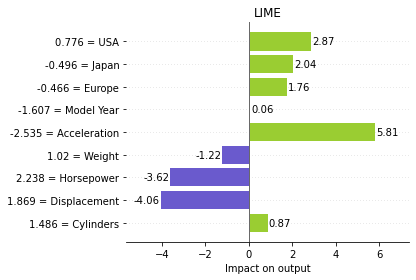

In [18]:
plot_feature_impact(explanation[0], features_name, test_features[0])
plt.title('LIME')
plt.show()

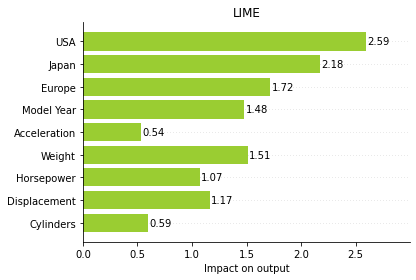

In [19]:
plot_mean_feature_impact(explanation, features_name)
plt.title('LIME')
plt.show()

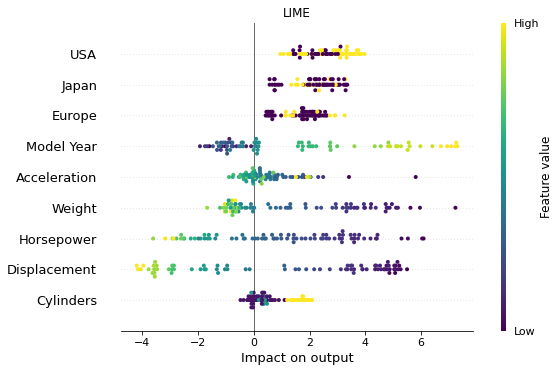

In [20]:
summary_plot_tabular(
    explanation,
    features_values=test_features,
    features_name=features_name
)
plt.title('LIME')
plt.show()

### Compute variance analytically

In [ ]:
# Explain one sample
ex_ind = 0
ex_row, ex_target = np.expand_dims(inputs_tf[ex_ind], axis=0), np.expand_dims([1], axis=0)
ex_exp = explainer(ex_row, ex_target)

In [ ]:
# Compute derivative of explanation w.r.t model weights via FDM
dx = 1e-3
n = model.layers[-1].weights[0].shape[0] # number of weights in the final Dense layer (without bias)
m = ex_exp.shape[1]
derivative_e_x = np.zeros((m, n))

# For every weight perturbation, we get a new column in the Jacobian
for i in range(n):
    # Perturb current weight in the model
    perturbed_model = tf.keras.models.load_model(model_path)
    weights, bias = perturbed_model.layers[-1].get_weights()
    weights[i] += dx
    perturbed_model.layers[-1].set_weights([weights, bias])

    # Compute explanations for perturbed model
    explainer = Lime(perturbed_model)
    perturbed_exp = explainer(ex_row, ex_target)

    # Compute FDM
    derivative_e_x[:, i] = (perturbed_exp - ex_exp) / dx

In [23]:
ex_exp

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[ 1.092, -2.108, -2.636, -1.096,  4.429, -0.779,  1.023,  1.179,
         3.711]], dtype=float32)>

In [24]:
perturbed_exp

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[ 1.066, -2.384, -2.583, -1.557,  4.459, -0.872,  0.8  ,  0.987,
         3.923]], dtype=float32)>

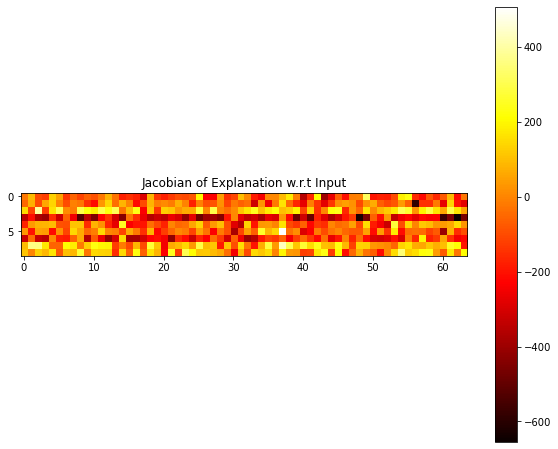

In [26]:
plt.figure(figsize=(10,8))
plt.imshow(derivative_e_x, cmap='hot')
plt.title("Jacobian of Explanation w.r.t Input")
plt.colorbar()
plt.show()

In [27]:
# Approximate covariance of explanation
perturbation_std = 0.1
sigma_squared = perturbation_std ** 2
variance_explanation = sigma_squared * derivative_e_x @ derivative_e_x.T

# Total variance is the trace of the cov. matrix
print("Total Variance of Explanation (Analytical):", np.trace(variance_explanation))

Total Variance of Explanation (Analytical): 215625.84403933454


In [28]:
# Normalized total variance is the trace of the cov. matrix divided by the L2-norm of the unperturbed explanation
print("Normalized Variance of Explanation:", np.trace(variance_explanation) / np.linalg.norm(explanation))

Normalized Variance of Explanation: 3020.4616097121184


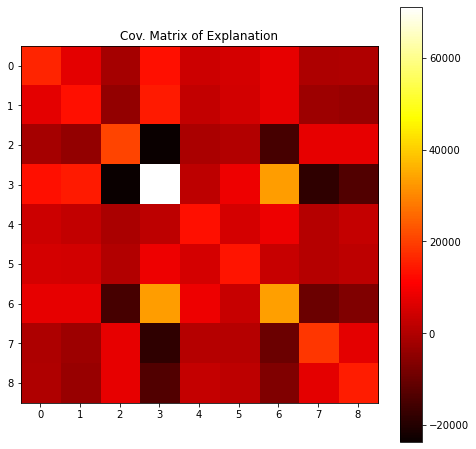

In [29]:
plt.figure(figsize=(8,8))
plt.imshow(variance_explanation, cmap='hot')
plt.title("Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

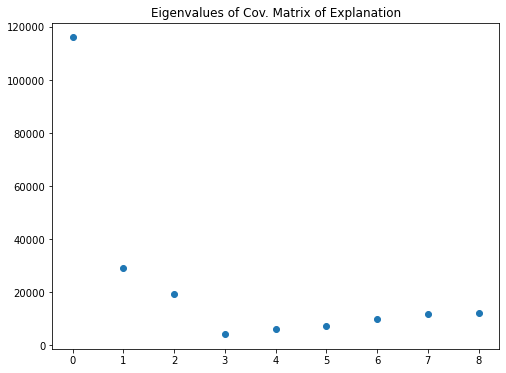

In [30]:
# Explained variance ratio
evals, evecs = np.linalg.eig(variance_explanation)

plt.figure(figsize=(8,6))
plt.plot(evals, 'o')
plt.title('Eigenvalues of Cov. Matrix of Explanation');

### Compute variance empirically

In [32]:
num_perturbations = 10
perturbation_std = 0.1  # same as above for analytical formula
sigma_squared = perturbation_std ** 2

perturbed_explanations = []
for _ in range(num_perturbations):
    # Add Gaussian noise to the model weights
    perturbed_model = tf.keras.models.load_model(model_path)
    weights, bias = perturbed_model.layers[-1].get_weights()
    weights += np.random.normal(0, perturbation_std, weights.shape)
    perturbed_model.layers[-1].set_weights([weights, bias])

    # Compute explanations for perturbed rows
    explainer = Lime(perturbed_model)
    perturbed_explanations.append( explainer(ex_row, ex_target) )

# Stack explanations and compute covariance matrix
explanation_matrix = np.stack(perturbed_explanations, axis=0).squeeze()
empirical_covariance = np.cov(explanation_matrix, rowvar=False)

# Compute total variance (trace of the covariance matrix)
empirical_total_variance = np.trace(empirical_covariance)

print("Empirical Total Variance of Explanation:", empirical_total_variance)

Empirical Total Variance of Explanation: 0.4211186656802983


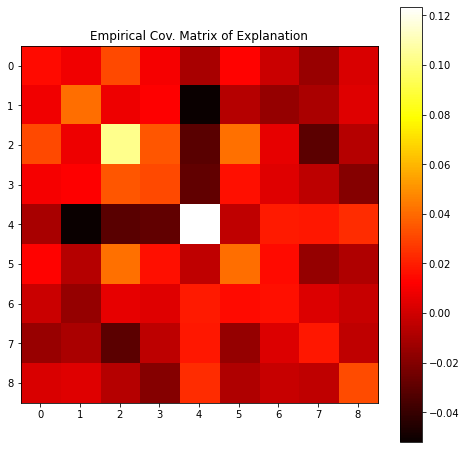

In [33]:
plt.figure(figsize=(8,8))
plt.imshow(empirical_covariance, cmap='hot')
plt.title("Empirical Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

### Analytical vs Empirical (multiple methods, multiple variances)

In [35]:
xai_methods  = {'Saliency': Saliency,
                'IntegratedGradients': IntegratedGradients,
                'KernelShap': KernelShap,
                'Lime': Lime,
                'Occlusion': Occlusion,
                'GuidedBackprop': GuidedBackprop,
                'GradientInput': GradientInput}
stds = [0.1, 0.2, 0.3, 0.4, 0.5] # std. deviations
num_perturbations = 10 # for empirical cov.
dx = 1e-3 # differential for ana. cov.

ex_ind = 0 # index of sample to explain
ex_row, ex_target = np.expand_dims(inputs_tf[ex_ind], axis=0), np.expand_dims([1], axis=0)
n = model.layers[-1].weights[0].shape[0] # number of weights in the final Dense layer (without bias)
m = len(features_name)

# Store results for plotting
results  = {name: {'analytical': [], 'empirical': []} for name in xai_methods.keys()}
cov_mats = {name: {'analytical': [], 'empirical': []} for name in xai_methods.keys()}

for name, constructor in xai_methods.items():
    print('\n' + name)
    explainer = constructor(model) # instantiate explainer with default params
    explanation = explainer(ex_row, ex_target) # sample explanation

    # Precompute Jacobian (stays fixed for every std)
    derivative_e_x = np.zeros((m, n))
    # For every feature perturbation, we get a new column in the Jacobian
    for i in range(n):
        # Perturb current weight in the model
        perturbed_model = tf.keras.models.load_model(model_path)
        weights, bias = perturbed_model.layers[-1].get_weights()
        weights[i] += dx
        perturbed_model.layers[-1].set_weights([weights, bias])

        # Compute explanations for perturbed model
        explainer = constructor(perturbed_model)
        perturbed_exp = explainer(ex_row, ex_target)

        # Compute FDM
        derivative_e_x[:, i] = (perturbed_exp - ex_exp) / dx
    
    for std in stds:
        ### Analytical
        sigma_squared = std ** 2
        covariance_ana = sigma_squared * derivative_e_x @ derivative_e_x.T
        
        # Total variance is the trace of the cov. matrix
        print("Analytical Variance (std = ", std, "):", np.trace(covariance_ana))
        results[name]['analytical'].append(np.trace(covariance_ana))
        cov_mats[name]['analytical'].append(covariance_ana)
        
        ### Empirical
        perturbed_explanations = []
        for _ in range(num_perturbations):
            # Add Gaussian noise to the model weights
            perturbed_model = tf.keras.models.load_model(model_path)
            weights, bias = perturbed_model.layers[-1].get_weights()
            weights += np.random.normal(0, perturbation_std, weights.shape)
            perturbed_model.layers[-1].set_weights([weights, bias])

            # Compute explanations for perturbed rows
            explainer = constructor(perturbed_model)
            perturbed_explanations.append( explainer(ex_row, ex_target) )
        
        # Stack explanations and compute covariance matrix
        explanation_matrix = np.stack(perturbed_explanations, axis=0).squeeze()
        covariance_emp = np.cov(explanation_matrix, rowvar=False)
        
        print("Empirical Variance (std = ", std, "):", np.trace(covariance_emp))
        results[name]['empirical'].append(np.trace(covariance_emp))
        cov_mats[name]['empirical'].append(covariance_emp)


Saliency
Analytical Variance (std =  0.1 ): 21140214.274542578
Empirical Variance (std =  0.1 ): 0.35879253768676844
Analytical Variance (std =  0.2 ): 84560857.09817031
Empirical Variance (std =  0.2 ): 0.2152744822058581
Analytical Variance (std =  0.3 ): 190261928.47088322
Empirical Variance (std =  0.3 ): 0.33939279273271483
Analytical Variance (std =  0.4 ): 338243428.39268124
Empirical Variance (std =  0.4 ): 0.3320560913916478
Analytical Variance (std =  0.5 ): 528505356.86356425
Empirical Variance (std =  0.5 ): 0.2039864770865214

IntegratedGradients
Analytical Variance (std =  0.1 ): 3161292.4687993545
Empirical Variance (std =  0.1 ): 0.7113807664593207
Analytical Variance (std =  0.2 ): 12645169.875197418
Empirical Variance (std =  0.2 ): 0.3109297970637288
Analytical Variance (std =  0.3 ): 28451632.21919419
Empirical Variance (std =  0.3 ): 0.6386730363261952
Analytical Variance (std =  0.4 ): 50580679.50078967
Empirical Variance (std =  0.4 ): 0.584338567543975
Analytic

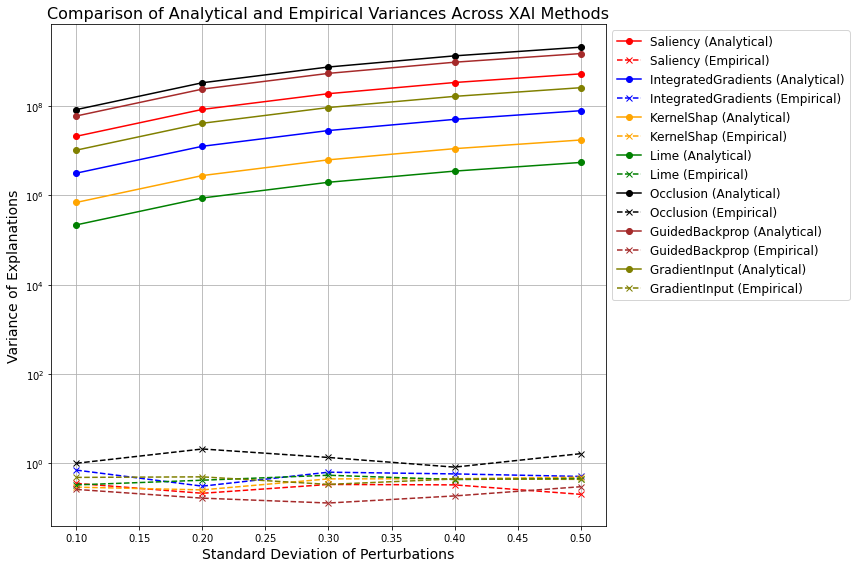

In [36]:
plt.figure(figsize=(12, 8))
colors=['red', 'blue', 'orange', 'green', 'black', 'brown', 'olive']
for (name, data), col in zip(results.items(), colors):
    plt.plot(stds, data['analytical'], marker='o', label=f"{name} (Analytical)", c=col)
    plt.plot(stds, data['empirical'],  marker='x', label=f"{name} (Empirical)", c=col, linestyle='dashed')

plt.xlabel('Standard Deviation of Perturbations', fontsize=14)
plt.yscale('log')
plt.ylabel('Variance of Explanations', fontsize=14)
plt.title('Comparison of Analytical and Empirical Variances Across XAI Methods', fontsize=16)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

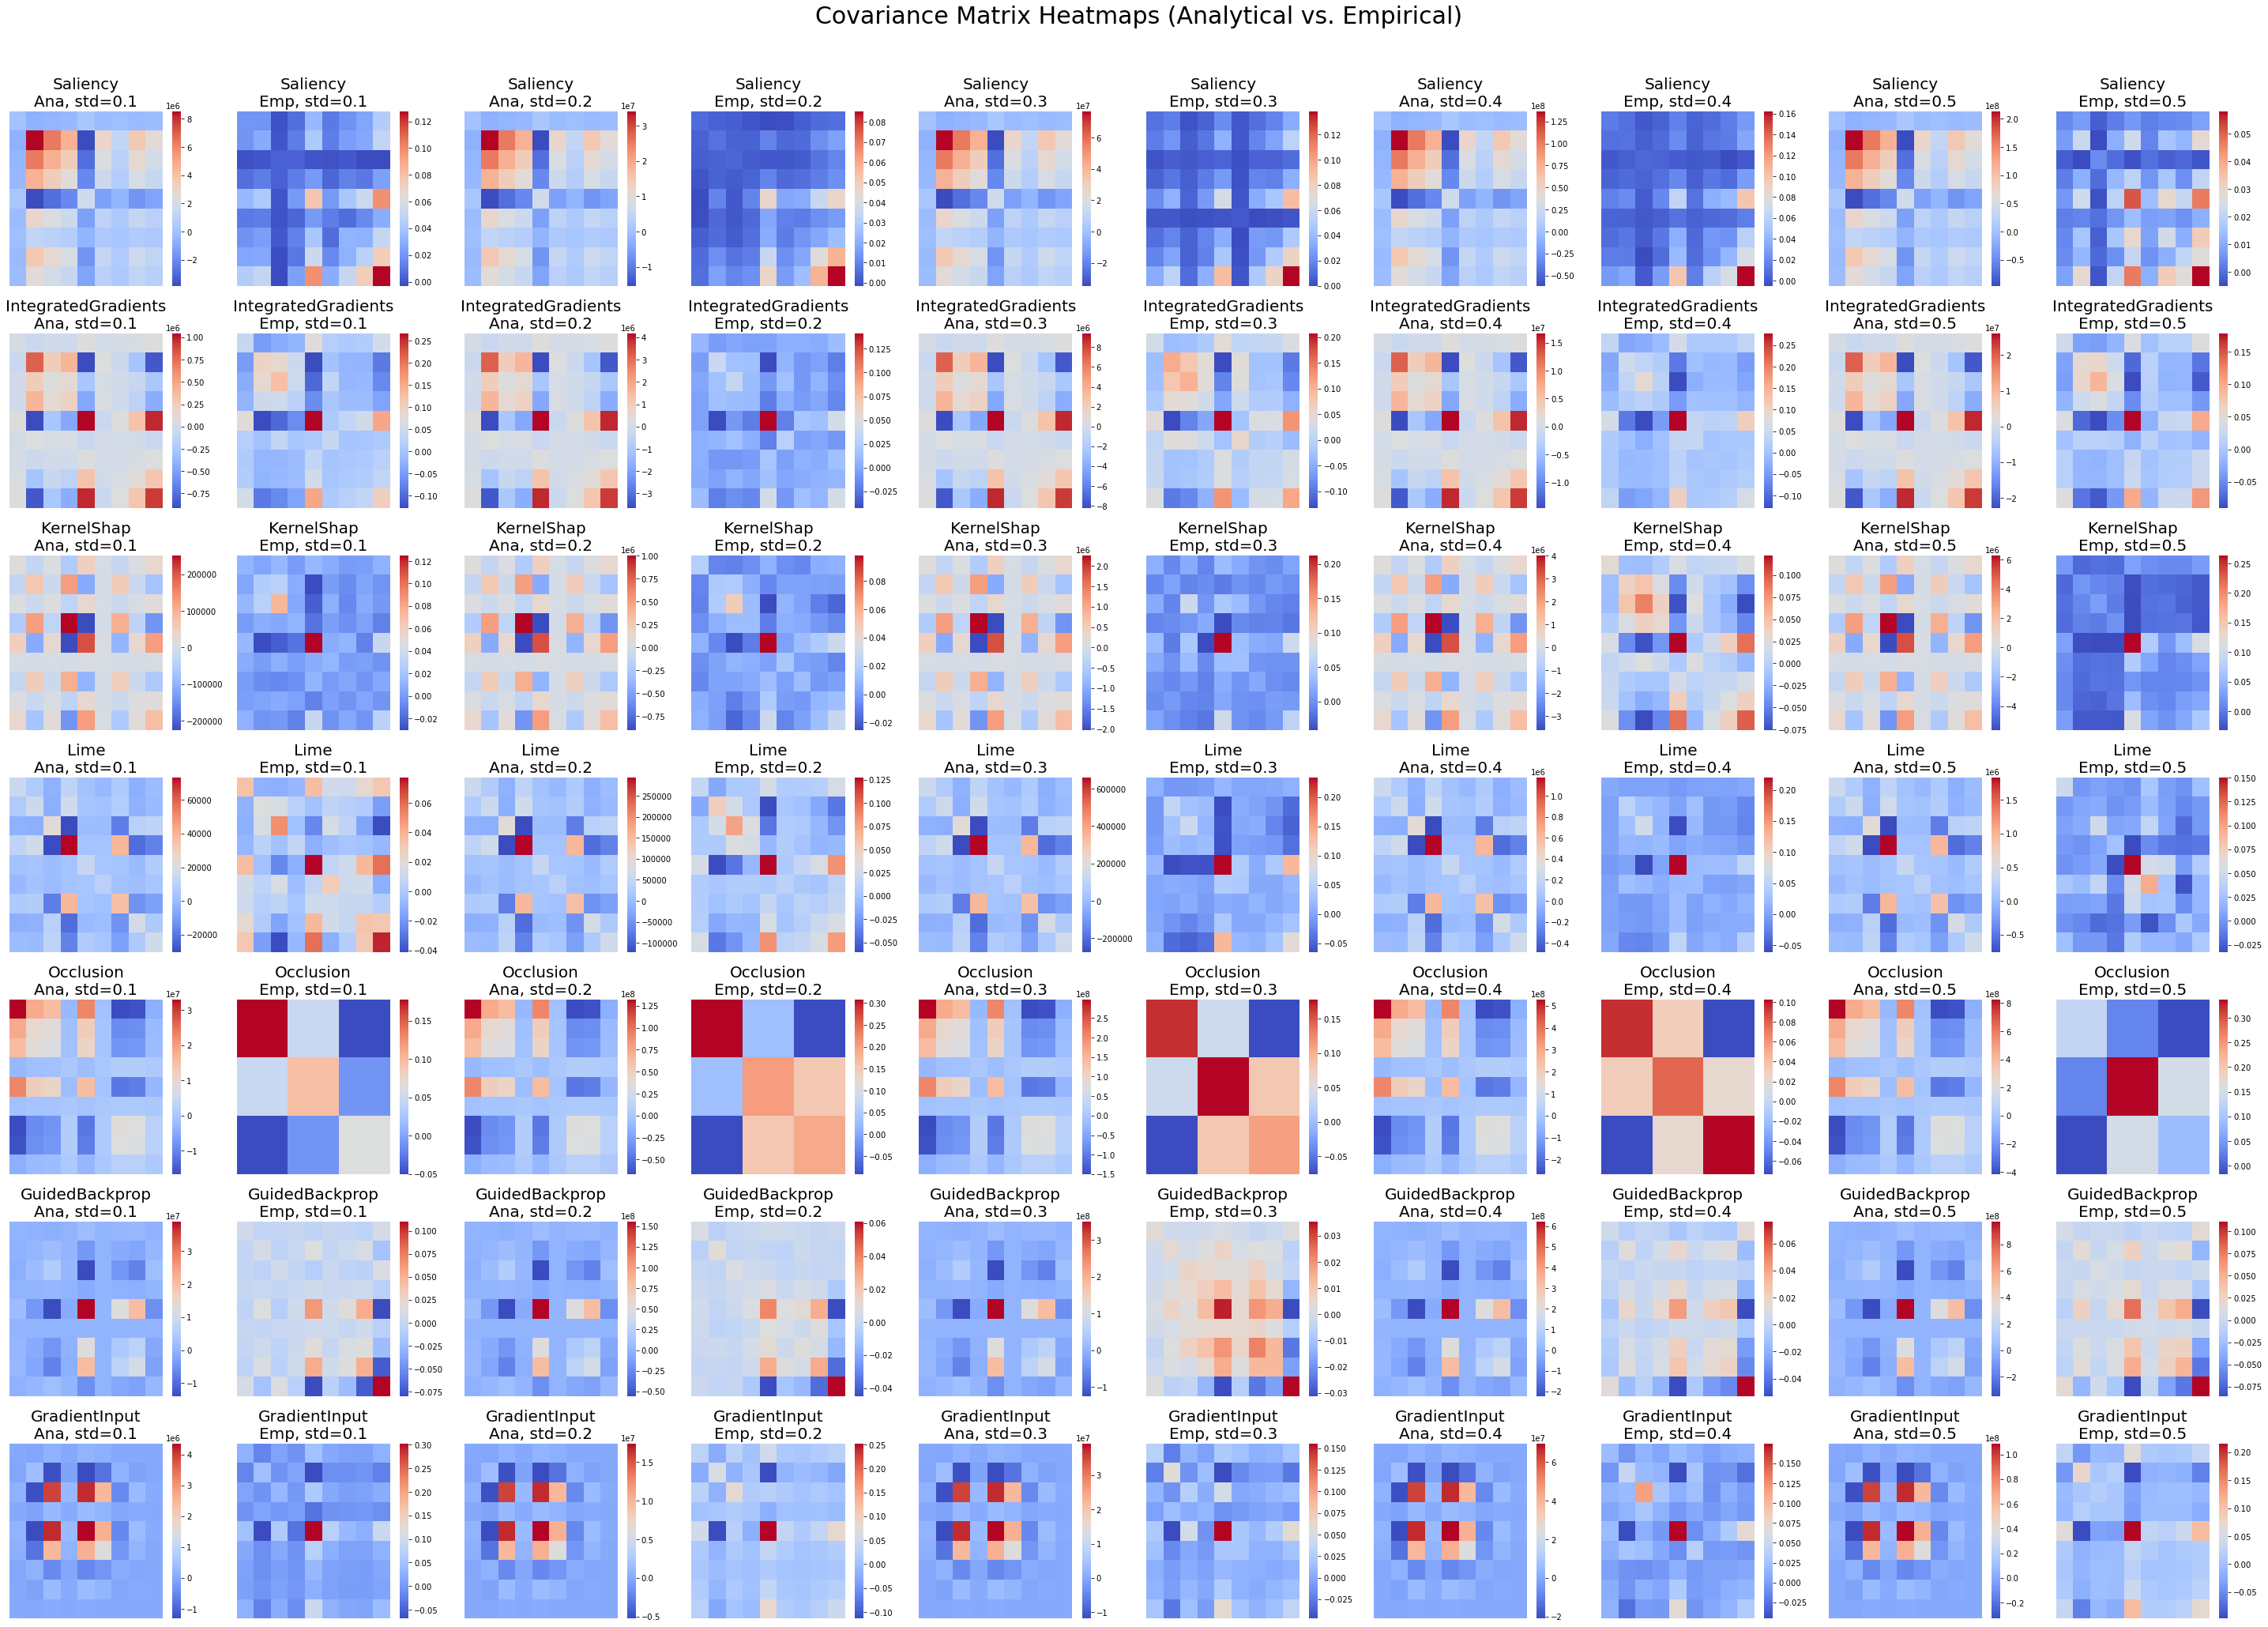

In [37]:
# Create heatmaps for all methods and perturbation stds
# Note: it may take 2 mins to display
def plot_heatmaps(cov_mats, stds):
    num_methods = len(cov_mats)
    num_stds = len(stds)

    fig, axes = plt.subplots(num_methods, num_stds * 2, figsize=(4 * num_stds * 2, 4 * num_methods))
    fig.suptitle('Covariance Matrix Heatmaps (Analytical vs. Empirical)', fontsize=30, y=1.02)

    for i, (name, cov_data) in enumerate(cov_mats.items()):
        for j, std in enumerate(stds):
            # Analytical covariance matrix
            cov_ana = cov_data['analytical'][j]
            ax = axes[i, j * 2]
            sns.heatmap(cov_ana, ax=ax, cmap="coolwarm", xticklabels=False, yticklabels=False, cbar=True)
            ax.set_title(f"{name}\nAna, std={std}", fontsize=20)
            ax.tick_params(left=False, bottom=False)

            # Empirical covariance matrix
            cov_emp = cov_data['empirical'][j]
            ax = axes[i, j * 2 + 1]
            sns.heatmap(cov_emp, ax=ax, cmap="coolwarm", xticklabels=False, yticklabels=False, cbar=True)
            ax.set_title(f"{name}\nEmp, std={std}", fontsize=20)
            ax.tick_params(left=False, bottom=False)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function to generate heatmaps
plot_heatmaps(cov_mats, stds)